In [58]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from inverse_warp import pixel2cam, pose_vec2mat, cam2pixel
from mc.visualisation import INTRINSICS, frame_to_tensor, tensor_to_frame

In [9]:
depth_img = np.full((64, 64, 1), 150, dtype=np.uint8)
depth = np.transpose(depth_img, (2, 0, 1))
depth = torch.from_numpy(depth.astype(np.float32))

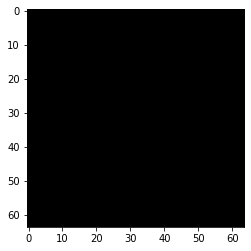

In [18]:
plt.imshow(depth_img, cmap="gray")
plt.show()

Transform depth to camera coordinate system:

In [19]:
cam_coords = pixel2cam(depth, INTRINSICS.inverse())

In [7]:
cam_coords.squeeze()[0][0]

tensor([-317.2829, -307.3678, -297.4527, -287.5376, -277.6226, -267.7075,
        -257.7924, -247.8773, -237.9622, -228.0471, -218.1320, -208.2169,
        -198.3018, -188.3867, -178.4716, -168.5565, -158.6414, -148.7264,
        -138.8113, -128.8962, -118.9811, -109.0660,  -99.1509,  -89.2358,
         -79.3207,  -69.4056,  -59.4905,  -49.5754,  -39.6604,  -29.7453,
         -19.8302,   -9.9151,    0.0000,    9.9151,   19.8302,   29.7453,
          39.6604,   49.5754,   59.4905,   69.4056,   79.3207,   89.2358,
          99.1509,  109.0660,  118.9811,  128.8962,  138.8112,  148.7263,
         158.6415,  168.5566,  178.4716,  188.3867,  198.3018,  208.2169,
         218.1320,  228.0471,  237.9622,  247.8773,  257.7924,  267.7075,
         277.6226,  287.5376,  297.4527,  307.3678])

In [8]:
cam_coords.squeeze()[1][0]

tensor([-317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829, -317.2829, -317.2829,
        -317.2829, -317.2829, -317.2829, -317.2829])

In [20]:
cam_coords.squeeze()[2][0]

tensor([150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
        150., 150., 150., 150.])

Transform pose vector to transformation matrix:

In [28]:
pose = np.array([1, 2, 3, 0, 0, 0])
pose = torch.from_numpy(pose.astype(np.float32)).unsqueeze(0)

In [29]:
pose_mat = pose_vec2mat(pose, "euler")
pose_mat

tensor([[[1., 0., 0., 1.],
         [0., 1., 0., 2.],
         [0., 0., 1., 3.]]])

Get projection matrix for camera frame to source pixel frame:

In [31]:
proj_cam_to_src_pixel = INTRINSICS @ pose_mat
rot, tr = proj_cam_to_src_pixel[..., :3], proj_cam_to_src_pixel[..., -1:]

In [33]:
rot

tensor([[[15.1285,  0.0000, 32.0000],
         [ 0.0000, 15.1285, 32.0000],
         [ 0.0000,  0.0000,  1.0000]]])

In [34]:
tr

tensor([[[111.1285],
         [126.2569],
         [  3.0000]]])

Apply the transformation and rotation to the camera coordinates:

In [42]:
src_pixel_coords = cam2pixel(cam_coords, rot, tr)
src_pixel_coords.shape

torch.Size([1, 64, 64, 2])

In [47]:
src_pixel_coords.squeeze()[:,:,0]

tensor([[-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838],
        [-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838],
        [-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838],
        ...,
        [-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838],
        [-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838],
        [-0.9769, -0.9458, -0.9147,  ...,  0.9216,  0.9527,  0.9838]])

In [48]:
src_pixel_coords.squeeze()[:,:,1]

tensor([[-0.9738, -0.9738, -0.9738,  ..., -0.9738, -0.9738, -0.9738],
        [-0.9427, -0.9427, -0.9427,  ..., -0.9427, -0.9427, -0.9427],
        [-0.9116, -0.9116, -0.9116,  ..., -0.9116, -0.9116, -0.9116],
        ...,
        [ 0.9247,  0.9247,  0.9247,  ...,  0.9247,  0.9247,  0.9247],
        [ 0.9559,  0.9559,  0.9559,  ...,  0.9559,  0.9559,  0.9559],
        [ 0.9870,  0.9870,  0.9870,  ...,  0.9870,  0.9870,  0.9870]])

Apply new camera to old frame:

In [56]:
img = imageio.imread("../mc/Navigation/v3_key_nectarine_spirit-3_3238-4450/frames/141.png")
img_tensor = frame_to_tensor(img)
projected_img = F.grid_sample(img_tensor, src_pixel_coords, padding_mode="zeros", align_corners=True)

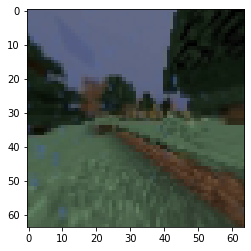

In [59]:
plt.imshow(tensor_to_frame(projected_img))
plt.show()